# Zillow Appraisal Predictions

# Goals:
* identify features that contribute to single family property tax value
* use machine learning regression models to predict single family property tax values

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import acquire

# Acquire

* Accquired data from noether sequal server
* data obtained 1/15/2023
* 2,858,627 rows by 59 columns before cleaning
* Each row represents a property
* Each column represents a characteristic of a property


# Prepare
* Removed columns all columns except square feet, tax_value, bedrooms, and bathrooms
* Checked for nulls in the data and removed them
* Checked for duplicate data and removed them
* Checked for outliers and removed them
* Split data into train, validate and test (approx. 60/25/15), stratifying on 'tax_value'
* Scaled continuous variables


# Data Dictionary




| Feature | Definition |
|:--------|:-----------|
|tax_value(target)| this is the properties appraisal value|
|bedrooms| this is the number of bedrooms on the property|
|bathrooms| this is the number of bathrooms on the property|
|sqft| This number represents the total area of a property in square feet.|
|lm_rmse| root mean squared deviation for the classic Linear Regression model|
|lassopoly| root mean squared deviation for the classic LASSO model|
|poly_rmse| root mean squared deviation for the classic Polynomial Regression model|
|baseline| root mean squared deviation using baseline|
|LASSO| Least Absolute Shrinkage and Selection Operator|
|LARS| Least Angle Regression|


## A Brief look at data

In [2]:
train, val, test = acquire.wrangle_zillow()
train



,sqft,bedrooms,bathrooms,tax_value
3030,1225.0,3.0,1.0,1014822.0
47117,2462.0,4.0,3.0,524894.0
7981,982.0,3.0,2.0,413692.0
2392,1748.0,2.0,2.0,272033.0
2925,1851.0,4.0,3.0,554009.0
...,...,...,...,...
34526,1810.0,3.0,2.0,338167.0
5859,1080.0,3.0,1.0,340520.0
3928,2096.0,4.0,2.5,797361.0
44866,913.0,2.0,1.0,283501.0


In [3]:
(train.tax_value.mean() + val.tax_value.mean() + test.tax_value.mean()) / 3 #establishing baseline

397784.63079456455

# Explore

* What is a property's appraisal value?
* What variables correlate with each other?
* Can the number of bedrooms a property have help us know a property's appraisal value?
* Can the number of bathrooms a property have help us know a property's appraisal value?
* Does the area of a property help us predict tax_value?

## What is a property's appraisal value?

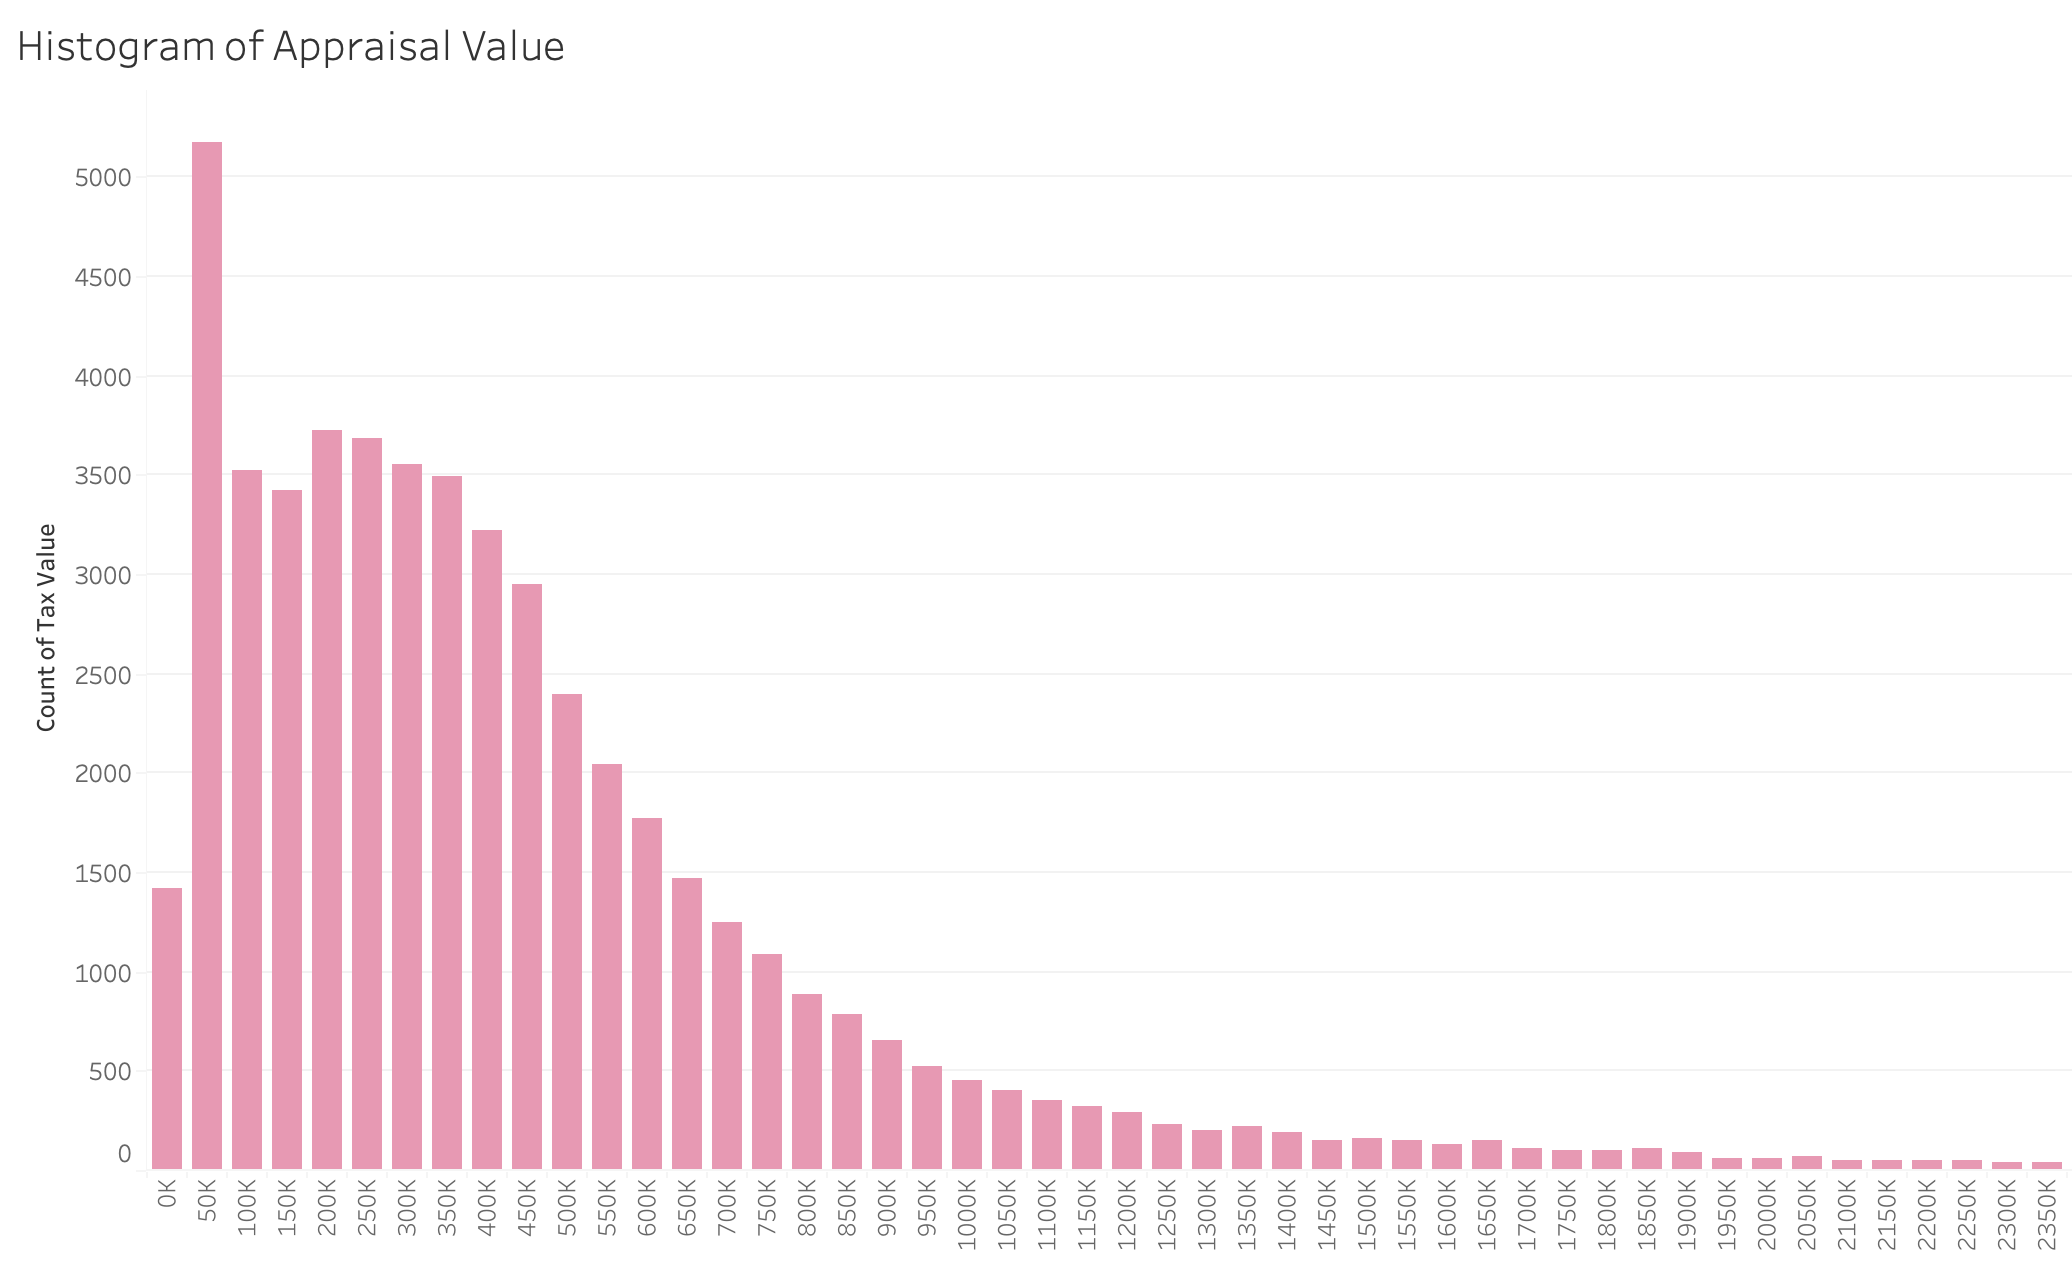

Distribution of Tax Value is skewed right with a median around 250,000

## What variables correlate with each other?

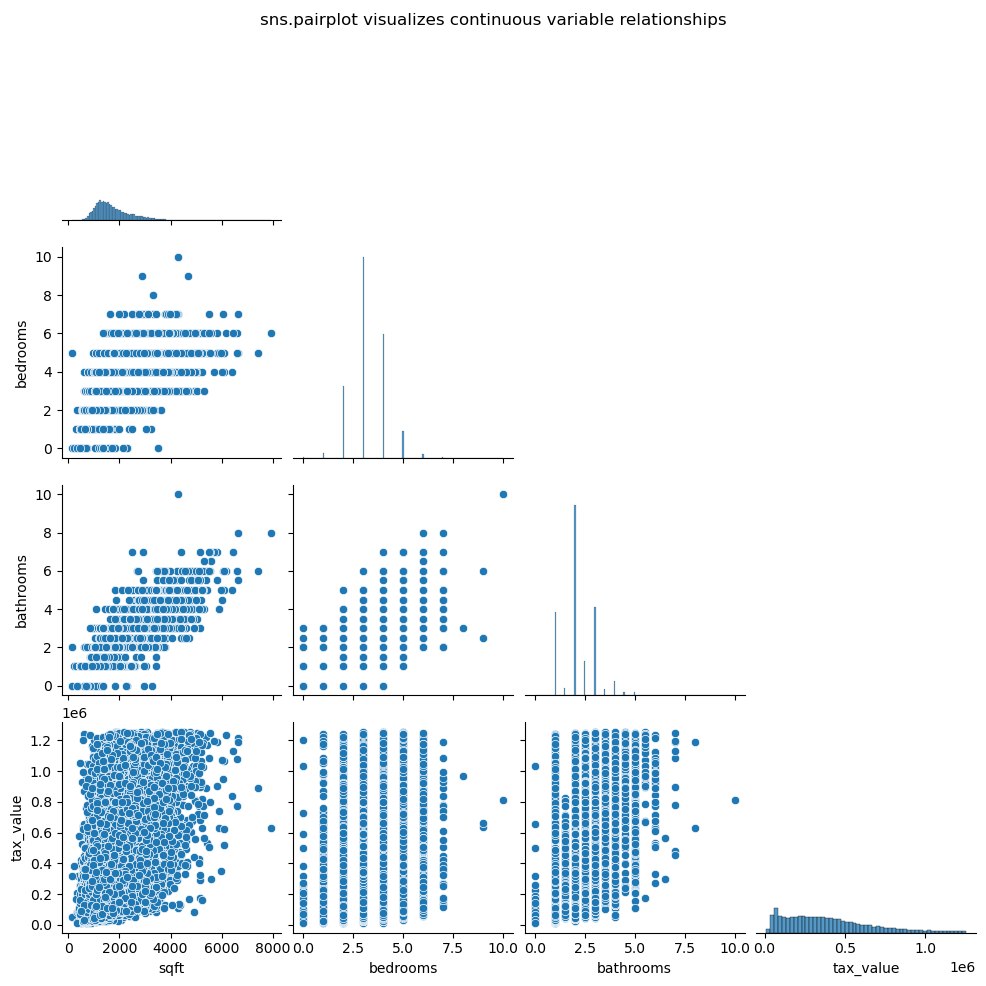

In [4]:
#plotting variables of interest into a pairplot to compare relationships
sns.pairplot(train, corner=True)
plt.suptitle("sns.pairplot visualizes continuous variable relationships")
plt.show()

it appears that bedrooms and square feet, bedrooms and bathrooms, and tax_value and sqare feet all have a positive correlation.

## Can the number of bedrooms a property have help us know a property's appraisal value?

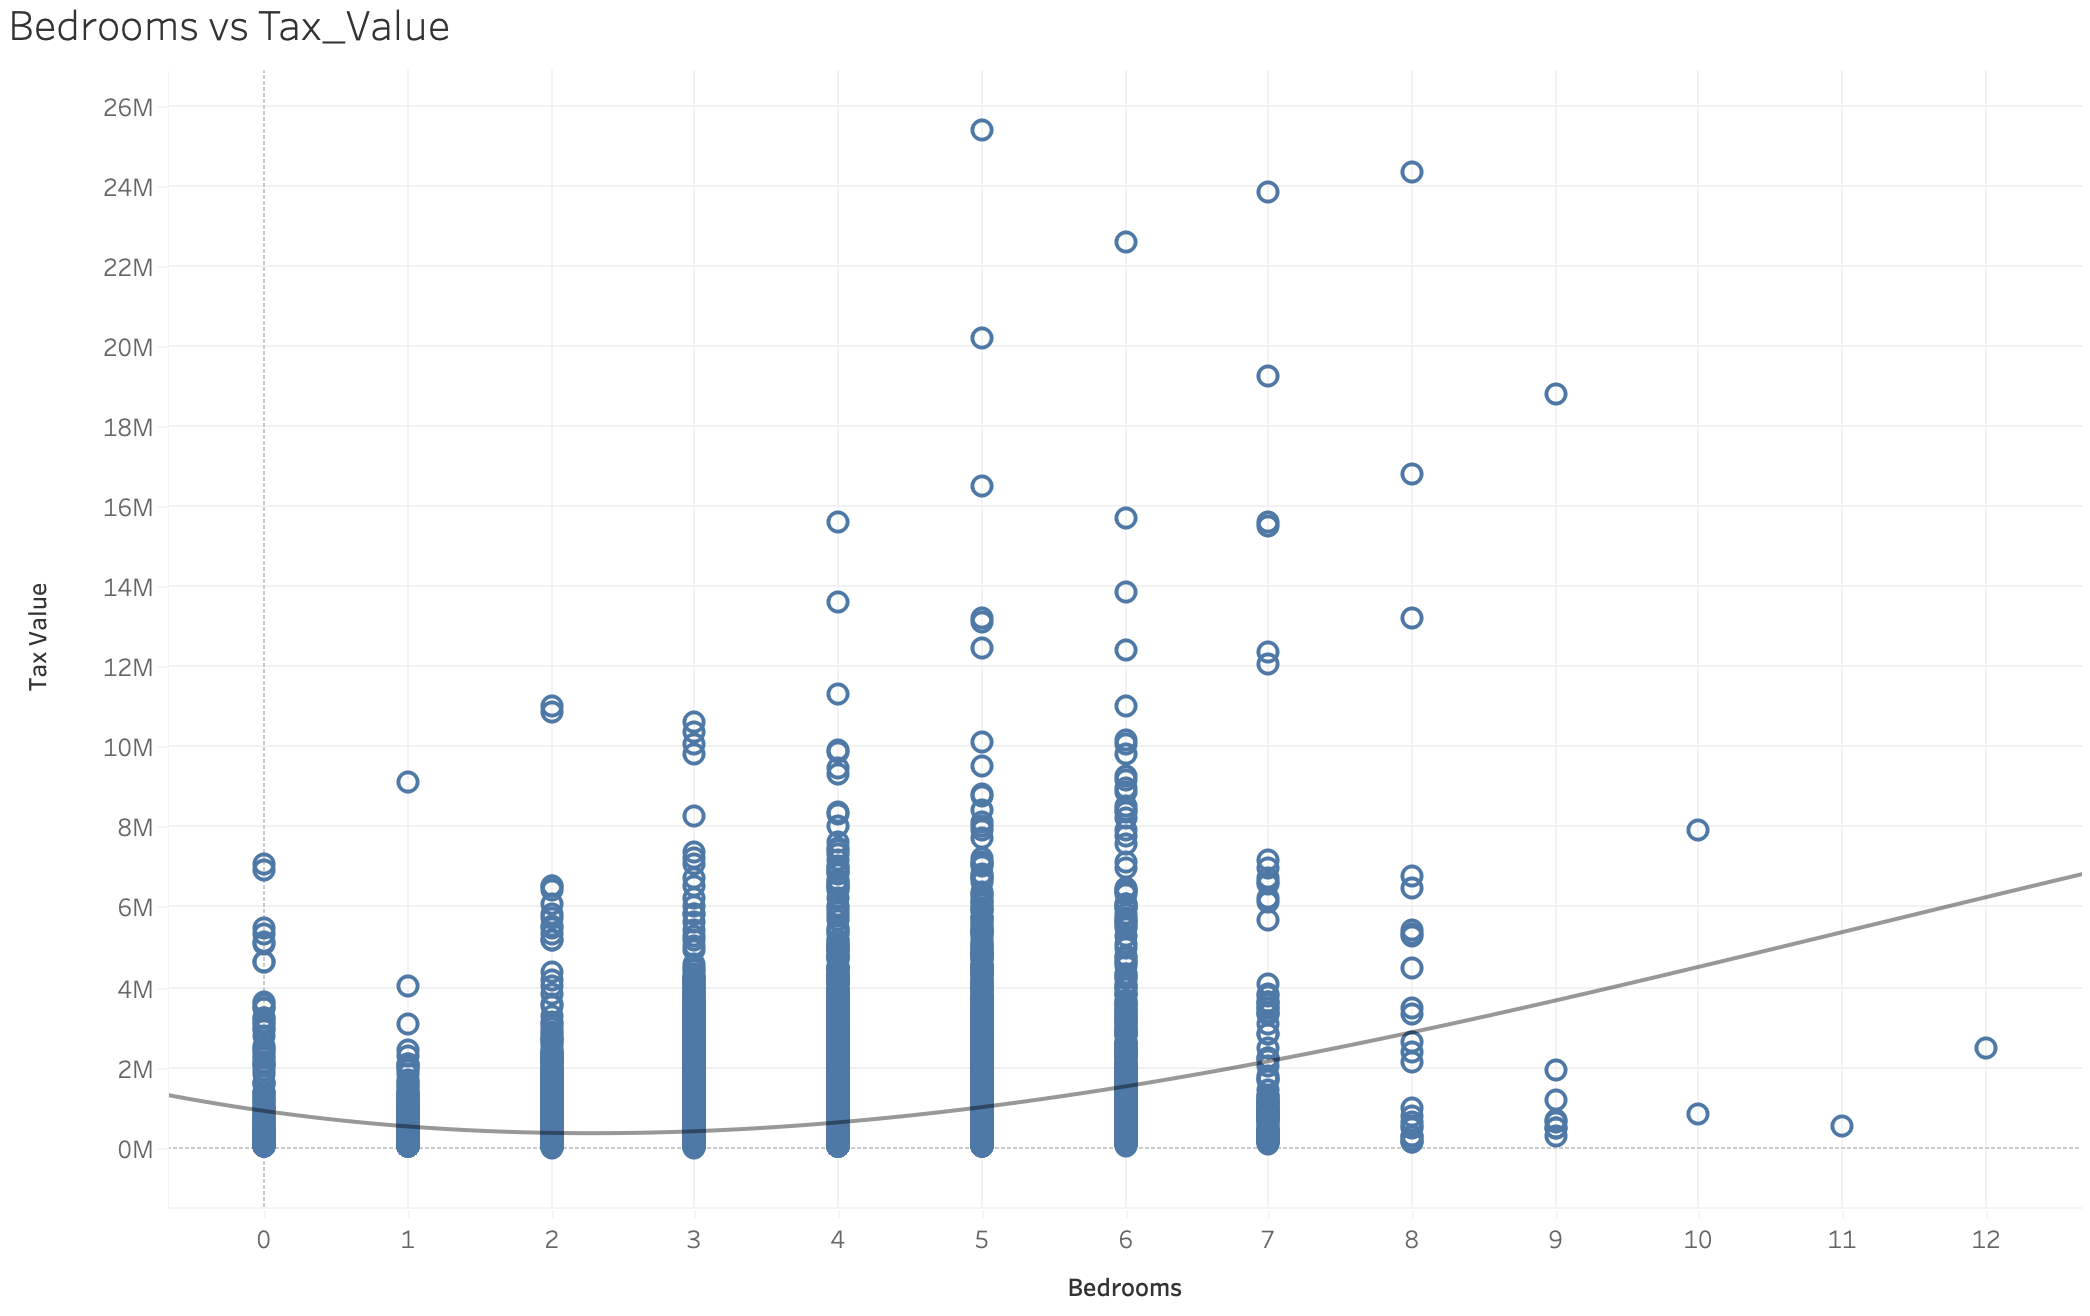

It appears bedrooms and tax value have a polnomial relationship.

## Can the number of bathrooms a property have help us know a property's appraisal value?

![SNOWFALL](bathrooms.png)

### Ho: there is not a correlation between bathrooms and tax value
### Ha: there is a correlation between bathrooms and tax value

In [5]:
# perform statistical test to analyze validity of visual representation and correlation
r, p = stats.pearsonr(train['bathrooms'], train['tax_value'])
r, p

(0.4493657403658945, 0.0)

Number of bathrooms vs tax value appears to have a positive correlation with r value of 0.44. R value indicates weak positive correlation. It appears number of bathrooms would be a better predictor of tax value than bedrooms.

## Does the area of a property help us predict tax_value?

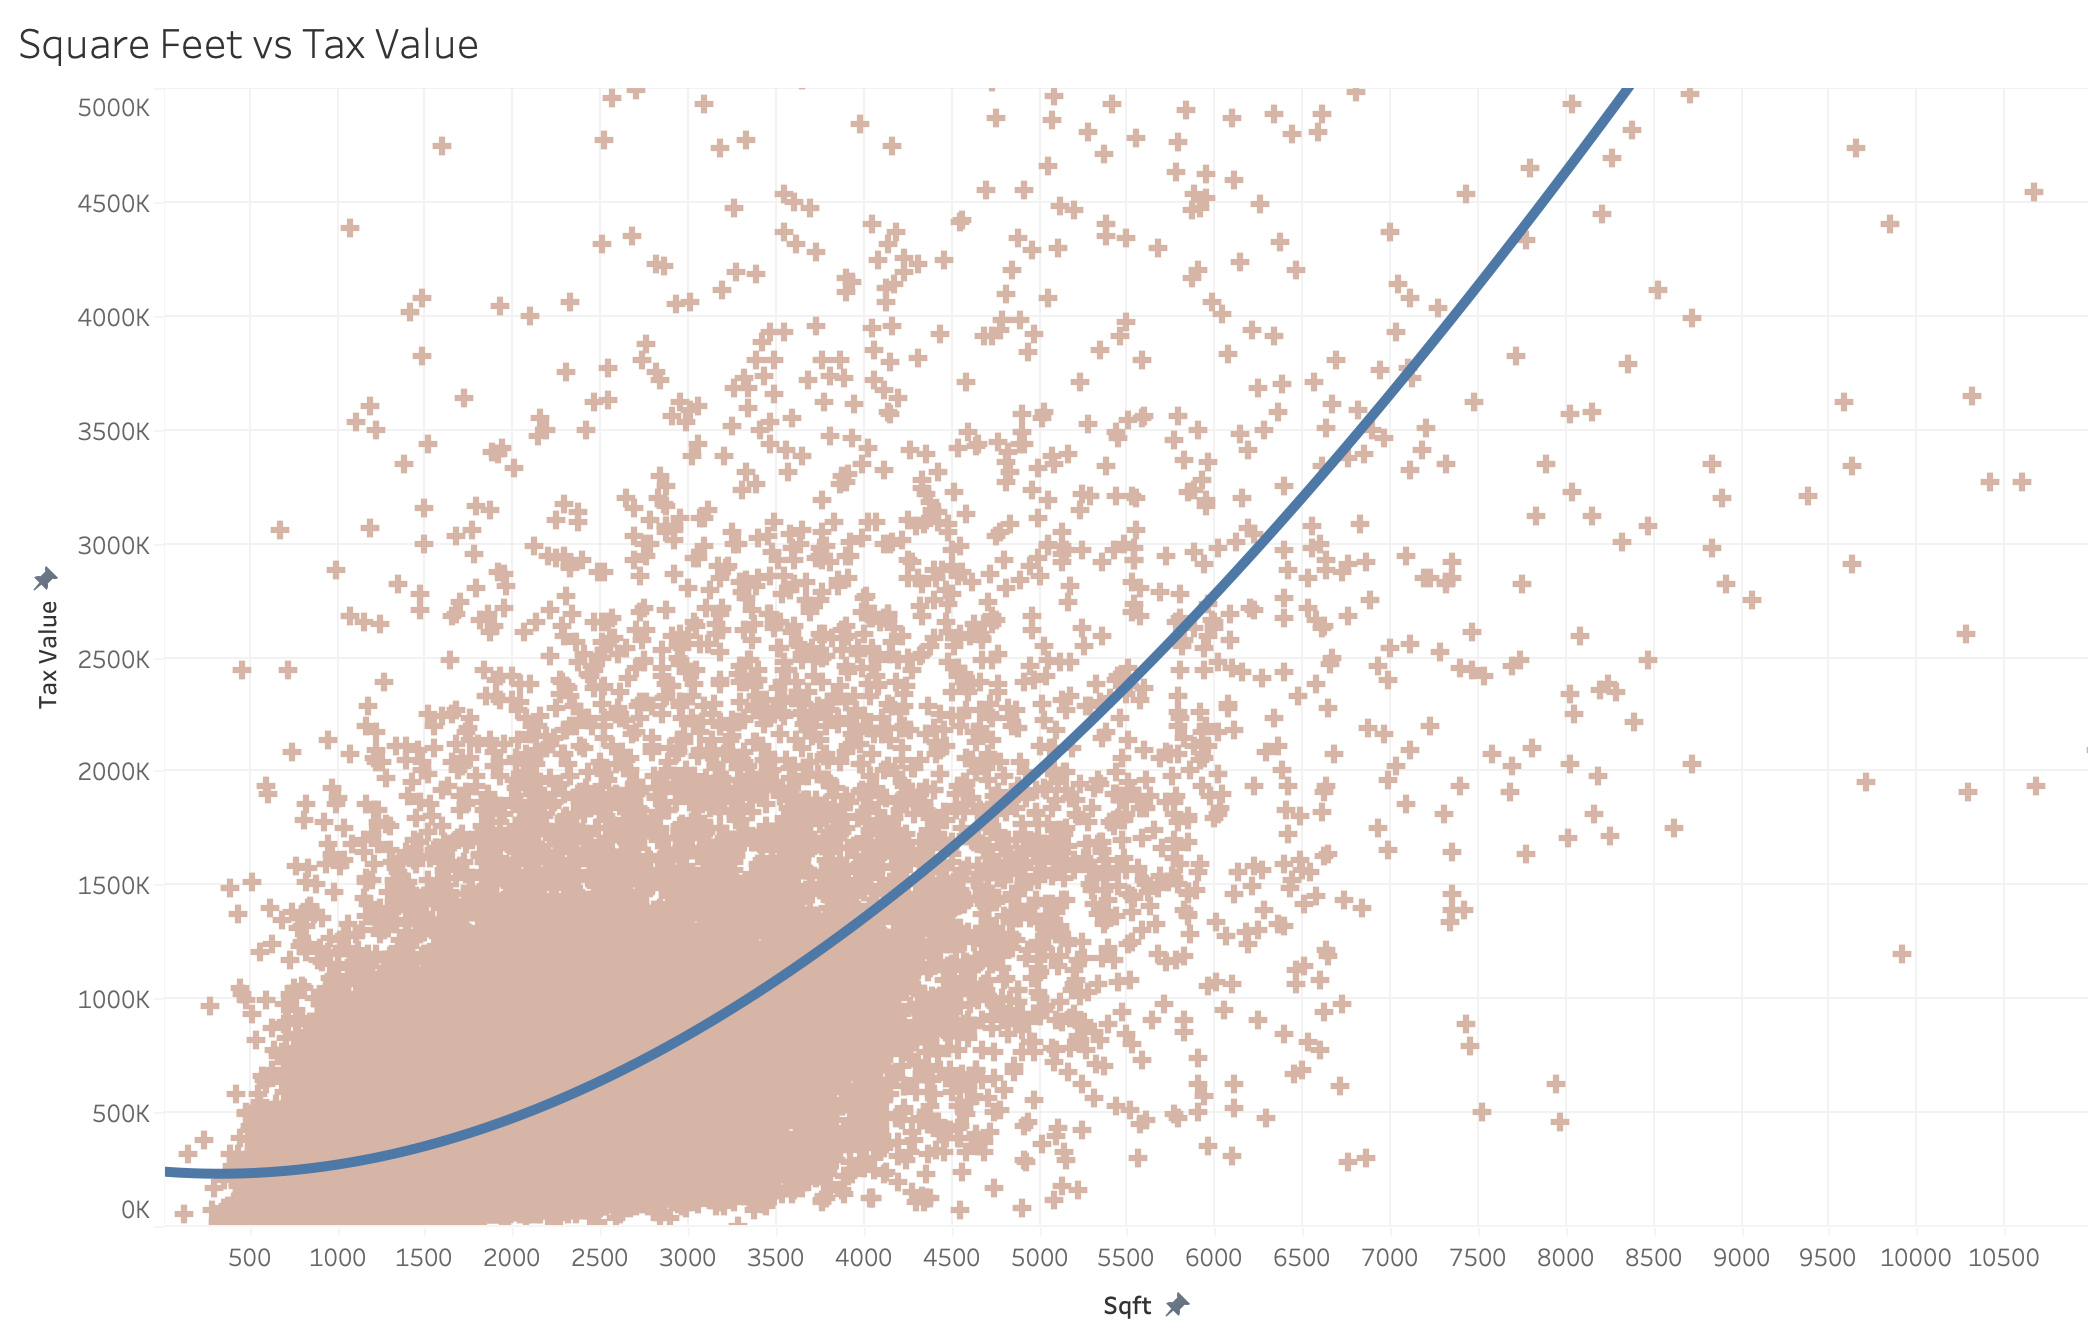

Square feet vs Tax value has a polynomial relationship. R value of 0.43 which indicates area/square feet is the best predictor of the 3 features explored.

* confidence interval of 95%
* and alpha value of 0.05

### Ho: there is not a correlation between square feet and tax value
### Ha: there is a correlation between square feet and tax value

In [6]:
# perform statistical test to analyze validity of visual representation and correlation
r, p = stats.pearsonr(train['sqft'], train['tax_value'])
r, p

(0.5138227529425977, 0.0)

The r value of 0.43 and p value of less that .05 indicates a moderate positive correlation between property area and tax value. Judging by other attributes analyzed these two variables appear to be the best ones to use when making our model.

# Exploration Summary

* Majority of houses appraised between 50 thousand and 500 thousand
* number of bedrooms and tax value have a very weak positive linear correlation
* number of bathrooms and tax value have a positive correlation
* Property area and tax value have the strongest relationship in data
    * r value indicates moderate positive polynomial correlation
* all features in explore will be used in our model because of the weak to moderate correlation between them

# Features I'm modeling with

* tax value (target)
* number of bedrooms
* number of bathrooms
* total area of property

# Modeling

* I will use accuracy as my evaluation metric
* Average home value is 397,784 (without outliers)

Modeling
* I will use root mean square deviation as my evaluation metric
    * this is because I will be using regression models to predict tax values and this value gives me the most real world comparison when evaluating my models

* 397,784 will be the baseline accuracy I use for this project which is the mean of all the single family homes in the dataset
* I will be evaluating models developed using four different model types and various hyperparameter configurations * Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test data

Scaling data

In [7]:
train = acquire.scale(train)
val = acquire.scale(val)
test = acquire.scale(test) 
#function that scales data

In [8]:
models = acquire.ols(train) # function that generates table of actual and predicted values for each model on
# train dataset
models

,actual,lm_preds,lasso_preds,poly_preds,tweedie_preds,baseline
3030,1014822.0,255668.326375,255689.232102,263762.556648,279662.062709,397784
47117,524894.0,519005.131867,519001.622856,529229.074811,488004.465348,397784
7981,413692.0,255202.310806,255212.814253,234351.133878,287726.030887,397784
2392,272033.0,435658.257385,435626.897159,439049.703738,402193.544211,397784
2925,554009.0,409834.042056,409841.695971,406349.537293,397579.293640,397784
...,...,...,...,...,...,...
34526,338167.0,403146.111729,403141.487676,410527.123235,379828.933776,397784
5859,340520.0,229760.293605,229783.848471,234300.560510,266386.636668,397784
3928,797361.0,432133.546717,432144.145436,438665.005318,408545.402968,397784
44866,283501.0,243511.450013,243510.187050,245349.269796,272310.808676,397784


In [9]:
rmse = acquire.calc_rmse(models) 
rmse    #function calculates root mean square deviation for all of our tests on train dataset

,lm_rmse,lasso_rmse,poly_rmse,tweedie_rmse,base_rmse
0,230194.677632,230194.67855,229888.467075,236522.479926,270949.700856


* polynomial model appears to be the best

In [10]:
validates = acquire.ols(val) #predictions for validate dataset
validates

,actual,lm_preds,lasso_preds,poly_preds,tweedie_preds,baseline
21125,685327.0,490926.323811,490928.864202,499364.518835,454422.710817,397784
32448,578714.0,639429.801951,639411.796873,651753.033837,635896.875742,397784
27357,378340.0,516263.191966,516245.442525,524593.800000,488091.884204,397784
30526,951803.0,835402.203844,835382.238931,824345.201573,922551.685710,397784
35850,54612.0,300518.768527,300522.879615,294783.475399,316369.676761,397784
...,...,...,...,...,...,...
35971,510433.0,462050.815319,462036.856844,467046.600052,442825.788642,397784
44175,667000.0,456025.407148,456033.775063,466741.993541,417062.772097,397784
34643,383665.0,307932.534652,307924.383175,302344.903736,314172.648275,397784
36728,570000.0,363527.193041,363526.898072,366931.736388,354259.655578,397784


In [11]:
rmse_val = acquire.calc_rmse(validates) 
rmse_val    #function calculates root mean square deviation for all of our models

,lm_rmse,lasso_rmse,poly_rmse,tweedie_rmse,base_rmse
0,232225.490002,232225.490394,231908.88581,239506.628503,271659.253786


In [12]:
#calculating difference between train and validate rmse values
rmses_for_models = pd.concat([rmse, rmse_val])
rmses_for_models = rmses_for_models.reset_index()
rmses_for_models = rmses_for_models.transpose()
rmses_for_models = rmses_for_models.rename(columns = {0 : 'train', 1 : 'validate'})
rmses_for_models['difference'] = rmses_for_models.train - rmses_for_models.validate
rmses_for_models

,train,validate,difference
index,0.000000,0.000000,0.000000
lm_rmse,230194.677632,232225.490002,-2030.812370
lasso_rmse,230194.678550,232225.490394,-2030.811844
poly_rmse,229888.467075,231908.885810,-2020.418735
tweedie_rmse,236522.479926,239506.628503,-2984.148577
base_rmse,270949.700856,271659.253786,-709.552930


# Comparing models

* Linear model, LASSO + LARS, tweedie, and polynomial regression models performed better than baseline
* Linear model and LASSO + LARS performed almost identically
* Explained variance score for polynomial regression model was the best
* all models did better than baseline
* polynomial regression had the smallest difference in rmse between train and validate dataframes
* I will be using the polynomial model on my test data set

In [13]:
test_data = acquire.ols(test)
rmse_for_test = acquire.calc_rmse(test_data)
pd.DataFrame(rmse_for_test['poly_rmse'])

,poly_rmse
0,232502.353727


* polynomial regression model for test dataset has rmse of 232,502.

# Conclusions

### Explore

* Majority of houses appraised between 50 thousand and 500 thousand
* number of bedrooms and tax value have a weak positive linear correlation
* number of bathrooms and tax value have a positive correlation
* Property area and tax value have the strongest relationship in data
* line of best fit for tax_value and square_feet was polynomial
    * r value indicates moderate positive polynomial correlation

### Modeling

* most models outperformed the baseline
* classic regression and lasso models had the most similar results
* polynomial regression model was the model that performed the best
    * this model only performed slightly better than classic regression and lasso models


### Recommendations

* gather more acurate data on home location
* use polynomial model on clusters of homes depending on where they are located
* obtain more real estate data from different sources i.e. realtor.com (county appraisal office)

### What's next

* Select zipcode as hyperparameters and run models again to get a better one
* work with data finding team to collect more data from homes